In [1]:
import matplotlib
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, h5py as h5
from matplotlib.cm import rainbow
from PreFRBLE.convenience import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *
from PreFRBLE.plot import *


# Rodrigues model for host and intervening galaxies (Rodrigues et al. 2018)


Rodrigues et al. provide a set of axisymmetric galaxy ensembles, obtained via GALFORM parameters derived by Lacey et al. 2016, which represent the population of galaxies in the Universe according to galaxy formation theory.
From these, we obtain the expected contribution to DM, RM and SM of FRBs via a Monte-Carlo simulation, probing LoS with random geometry through random galaxy models.
Here we translate the output of the Monte-Carlo simulation performed with magnetizer code by Luiz F. S. Rodrigues to format used in PrEFRBLE.
These results are given for different redshift bins than used in PrEFRBLE.
We obtain the likelihood functions used in PrEFRBLE by redshifting the average of nearest neighbours (comoving), transformed to proper values at the given redshift.

In [2]:
## model nmnemonic
model = 'Rodrigues18'

## file containing raw data
Rodrigues_datafile = '../../likelihood/Rodrigues_galaxy_raw.h5'

## file to contain average r_gal and n_gal
Rodrigues_file_rgal = '../../likelihood/Rodrigues_galaxy_radius.dat'


## number of redshift bins and bins in likelihood functions
N_z, N_bins = 60, 100  

## redshift bins in PreFRBLE
zs0 = redshift_bins
h = 0.703


In [3]:
def NearestNeighbor( x=1., xs=np.array([0.,1.,2.]) ):
    """ find nearst neighbor of x in xs """
    #print( np.diff( xs, axis=1, prepend=x) )
    dx = (xs - x)**2
    i_NN = np.where( dx == dx.min() )[0][0]
    return i_NN

def NearestNeighbors( x=1., xs=np.array([0.,1.,2.]) ):
    """ find nearst neighbors of x in xs """
    try:
        i_NN = np.where( xs >= x )[0][0]
    except:
        return np.array([-1])
    return np.array([-1,0]) + i_NN


def  LikelihoodStandardize( P=[], x=[], redshift=0.0, measure='DM' ):
    """ transform raw data format to standard format in PrEFRBLE """
        
    ## translate logarithmic bin central points to bin ranges
    dx = np.mean(np.diff(x))
    x = 10.**np.append( x[0]-dx/2, x+dx/2 )

    ## raw data is normalized to 1 = sum( P * diff( log10(DM) ) ), renormalize to 1 = sum( P * diff(DM) )
    P *= np.diff( np.log10(x) ) / np.diff( x )
    P /= np.sum( P*np.diff(x)) ## make it exact
                
    ## transform to proper values (data is written in residual frame)
    P, x = LikelihoodShift( x=x, P=P, shift=(1+redshift)**-scale_factor_exponent[measure] )
    
    ## use correct number of bins
    P, x = LikelihoodShrink( P=P, x=x, bins=N_bins )
    
    return P, x

### Standardize Likelihood
Here we read the raw output of Monte-Carlo simulation performed by Luiz F. S. Rodrigues (*Rodrigues_datafile*) and transform to the standards used in PrEFRBLE (*likelihood_file_galaxy*), i. e. number of bins in P, renormalization and redshift bins. Also saves average half-mass radius and number density of galaxies as function of redshift (*Rodrigues_file_rgal*).

In [8]:
n_gals, r_gals = [], []

with h5.File(Rodrigues_datafile,'r') as f:
    
    ## redshift bins of raw results
    zs = list(f.keys())
    zs_float = np.array(zs).astype('float')
    colors = list(Rainbow(zs0))
    for z0, c in zip(zs0, colors):

        ## find nearst neighbour redshift
        iz = NearestNeighbor( x=z0, xs=zs_float )
        
        izs = NearestNeighbors( x=z0, xs=zs_float )
        ## linear approximation
        weights = 1 - np.abs( zs_float[izs] - z0 )/np.diff(zs_float[izs])
        if izs[0] == [-1]:
            weights = [1]
    
        
        ## first, prepare correct redshift binning of r_gal and n_gal
        ## use approximation between nearest neighbours
        r_gal = np.sum( [ w*f['/'.join([zs[iz],"avg_radius"])][()] for iz, w in zip(izs, weights)] )  ## kpc
        n_gal = np.sum( [ w*f['/'.join([zs[iz],"number_density"])][()] for iz, w in zip(izs, weights)] )  ## Mpc^-3 comoving
        #'''
        n_gal *= (1+z0)**3 ## Mpc^-3
        
        n_gals.append(n_gal) 
        r_gals.append(r_gal)
        

        
#        """        
        for measure in ['DM','RM','SM'][1:]:
            for host in [True,False]:
                ## read raw data of nearest neighbours
                Ps, xs = [], []
                for iz in izs:
                    x = f['/'.join([zs[iz],"FRB_{}".format(measure) if host else measure])]['bins'][()] 
                    P = f['/'.join([zs[iz],"FRB_{}".format(measure) if host else measure])]['data'][()] 
                    
                    ## bring to standard form used in PrEFRBLE
                    P, x = LikelihoodStandardize( P=P, x=x, redshift=z0, measure=measure)
                    Ps.append(P)
                    xs.append(x)

                ## find the correspoding mean
                P, x = LikelihoodsAdd( Ps=Ps, xs=xs, log=True, weights=weights, renormalize=1)
                
                ## write to file
                if host:
                    keys = [ KeyHost( model=model, redshift=z0, measure=measure, axis=axis ) for axis in ['P','x'] ]
                else:
                    keys = [ Keyinter( model=model, redshift=z0, measure=measure, axis=axis ) for axis in ['P','x'] ]
                Write2h5( likelihood_file_galaxy, datas=[P,x], keys=keys )
        
with open( Rodrigues_file_rgal, 'w' ) as f:
    f.write( 'redshift\tr_gal\tn_gal\n' )
    for z, r, n in zip( zs0, r_gals, n_gals):
        f.write( "{0}\t{1}\t{2}\n".format(z,r, n) )

In [17]:
## this function delivers the expected number of galaxies along each LoS as function of source redshift
NInter(1.5)

0.09396817601882806

### plot redshift evolution of $n_{\rm gal}$ and $r_{\rm gal}$

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  del sys.path[0]


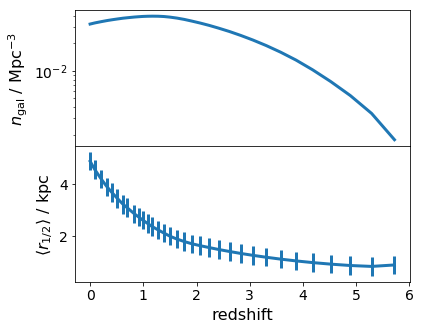

In [149]:
files = ['../../../PreFRBLE_2nd/data/galaxy_data_centrals.hdf5','../../../PreFRBLE_2nd/data/galaxy_data.hdf5']
h = 0.703

files= [Rodrigues_datafile]

fig, axs = plt.subplots( 2, 1, figsize=(6,5), sharex='all' )

for fn in files[:]:
    zs = []
    ns= []
    rs = []
    r_devs = []
    with h5.File(fn) as f:
#with h5.File('../../../PreFRBLE_2nd/data/galaxy_data.hdf5') as f:
        for k in f.keys():
            n=f[k+'/number_density'][()]
            r=f[k+'/avg_radius'][()]
            r_dev = f[k+'/std_radius'][()]
#            r=np.sqrt(f[k+'/avg_radius_squared'][()])
#            r_dev = f[k+'/std_radius_squared'][()]
            z = float(k)
            zs.append(z)
            ns.append(n) #*(1+z)**3)
#            ns.append(n*h**3)
            rs.append(r)
            r_devs.append(r_dev)
    axs[0].plot(zs,ns, lw=3)
    axs[1].errorbar(zs,rs, yerr=r_dev, lw=3)
axs[0].set_yscale('log')
#plt.plot(z_gal, n_gal)
axs[0].set_ylabel(r"$n_{\rm gal}$ / Mpc$^{-3}$", fontsize=16)
axs[1].set_ylabel(r"$\langle r_{1/2}\rangle$ / kpc", fontsize=16)
axs[1].set_xlabel('redshift', fontsize=16)
axs[0].set_yscale('log')
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=14)
plt.subplots_adjust(hspace=0.0)

### Intervening Galaxies

We combine the likelihood functions of intervening galaxies $P_{\rm inter}$ at redshift $z$ to likelihood function for contribution of intervening galaxies $P_{\rm Inter}$ of unknown redshift to LoS of source at redshift $z_s$. This is done by adding probabilities of different bins, weighted by the probability to intersect galaxy in that bin, $n_{\rm inter}(z)$. Here we compute that probability as well as the average number of intervening galaxies as function of source redshift
$$
N_{\rm Inter}(z_s) = \int\limits_0^{z_s} \pi r_{\rm gal}^2 n_{\rm gal} \frac{d_H(z)}{1+z} \text{d}z = \int \pi(z) \text{d}z = \sum n_{\rm inter}(z) 
$$
which is used to renormalize $N_{\rm Inter}(z) = \int P_{\rm Inter}(\text{DM}|z) \text{d}\text{DM}$.
$d_H$ is Hubble length.

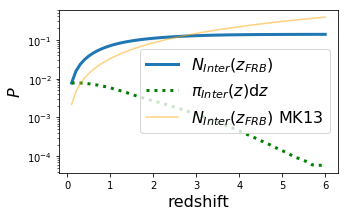

In [13]:
### plot likelihood for galaxies at redshift to intersect LoS, n_inter, which is used to weigh the redshift bins
### as well as expectet number of galaxies in LoS to source, N_inter

fig, ax = plt.subplots( figsize=(5,3) )


model = 'Rodrigues18'

#pi_inter = PriorInter( redshift_bins[-1], model=model )
n_inter = nInter( redshift_bins[-1], model=model )
N_inter = np.cumsum( n_inter)

plt.plot( redshift_bins, N_inter, label=r"$N_{Inter}(z_{FRB})$", lw=3 )
plt.plot( redshift_bins, n_inter, linestyle=':', label=r"$\pi_{Inter}(z)$d$z$", color='green', lw=3 )

model = 'Macquart13'
n_inter = nInter( redshift_bins[-1], model=model )
N_inter = np.cumsum( n_inter)
plt.plot( redshift_bins, N_inter, label=r"$N_{Inter}(z_{FRB})$ MK13", alpha=0.5, color='orange' )

plt.xlabel('redshift', fontsize=16)
plt.ylabel(r"$P$", fontsize=16)
plt.yscale( 'log')
plt.legend( fontsize=16)
AllSidesTicks(ax)


Finally, compute the full likelihood $P_{\rm Inter}$ for contribution of interverning galaxies of unknown type at unknown redshift to measures along LoS to source at redshift $z_s$ by summing the contribution of individual redshifts $P_{\rm inter}$ weighed by the intersection probability $\pi_{\rm inter}$.
$$
P_{\rm Inter} (DM|z_s) = \int P_{\rm inter}(DM|z) \pi_{\rm inter}(z) \text{d}z = \sum P_{\rm inter}( DM|z) n_{\rm inter}(z)
$$

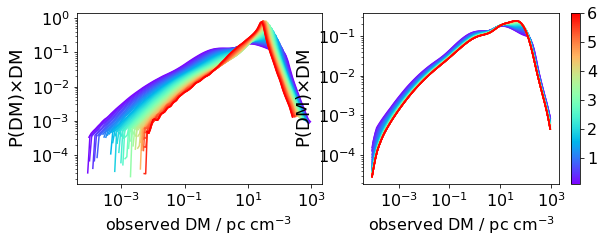

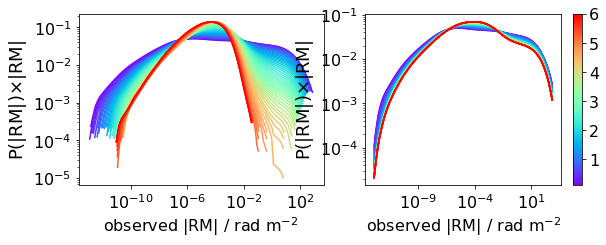

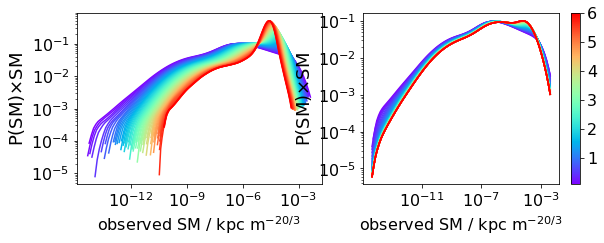

In [14]:
measures = [ 'DM', 'RM', 'SM' ]  ## scattering time needs special treatment in own notebook

fig, axs1 = plt.subplots( 1, 2, figsize=(8,3))
Colorbar(redshift_bins)
fig.tight_layout()
fig, axs2 = plt.subplots( 1, 2, figsize=(8,3))
Colorbar(redshift_bins)
fig.tight_layout()
fig, axs3 = plt.subplots( 1, 2, figsize=(8,3))
Colorbar(redshift_bins)
fig.tight_layout()
axs = [ axs1, axs2, axs3 ]

model='Rodrigues18'

weights = nInter( redshift_bins[-1], model=model )
## redshifts of intervening galaxy chosen in center of bin
redshift_L = redshift_bins - np.diff(redshift_range)/2


for measure, axs in zip( measures, axs ):
    for i_s, (z_s, color) in enumerate( zip( redshift_bins, rainbow( np.linspace(0,1,len(redshift_bins)) ) ) ):
        ## for source redshift
        Ps, xs = [], []
        for i_L , (z_L, color_L) in enumerate( zip( redshift_L[:i_s+1], rainbow( np.linspace(0,1,len(redshift_bins)) ) ) ):
            ### read and collect P_inter(DM|z_L) for all z_L <= z_s
            P, x = GetLikelihood_inter( redshift=redshift_bins[i_L], model=model, measure=measure)
            if i_s == len(redshift_bins) - 1:
                PlotLikelihood( x=x, P=P, measure=measure, color=color_L, ax=axs[0] )
            Ps.append(P)
            xs.append(x)
        ### integrate results for all intervening redshifts, weighing with differential intersection probability
        ### result is renormalized to 1, can be read out renormalized to N_inter with GetLikelihood_Inter( ..., N_inter=True )
        P, x = LikelihoodsAdd( Ps, xs, weights=weights[:i_s+1], renormalize=1 )
        PlotLikelihood( x=x, P=P, measure=measure, color=color, ax=axs[1] )
        Write2h5( filename=likelihood_file_galaxy, datas=[P,x], 
                 keys=[ KeyInter( redshift=z_s, model=model, measure=measure, axis=axis) for axis in ['P','x'] ] 
                )

plt.show()


### compare with Kierdorf et al.
depreceated for now, as waiting for data of prediction from single galaxy model with comparable global parameters in _Rodrigues_ sample

In [19]:
RM_M51 = np.genfromtxt('../../downloads/M51_RM_Sband.txt')
P, x = Histogram( np.abs(RM_M51)[RM_M51 != 0.0], log=True, bins=20, density=True, range=[1,200] )
PlotLikelihood( x, P, measure='RM' )
plt.title( 'M51 observed S-band')

OSError: ../../downloads/M51_RM_Sband.txt not found.

### Compute galaxy number density from galaxy mass function
This is not needed, since all the info is already encoded in results of Rodrigues et al.

In [18]:
### GSMF from other works

def Schechter( M, M_star=1, phi=1, alpha=1):
    """ Schechter function, Masses in log10(M_sun), phi in Mpc^-3 h^3 (determines unit of result) """
    M_ = 10.**M / 10.**M_star
    return phi * ( M_ )**alpha * np.exp( -M_ ) / M_star

    
def SchechterDouble( M, M_star=1, phi1=1, alpha1=1, phi2=1, alpha2=1):
    """ double Schechter function, Masses in log10(M_sun), phi in Mpc^-3 h^3 (determines unit of result) """
    M_ = 10.**M / 10.**M_star
    return ( phi1 * ( M_ )**alpha1 + phi2 * ( M_ )**alpha2 ) * np.exp( -M_ ) / M_star  ## M_ is ratio of M_sun, while M_star is log10(M_sun)


## Henriques et al 2015

def PlotGSMFHenriques( ax=None, **kwargs_plot ):
    """ Plot GSMF according to Henriques et al 2015 """
    if ax is None:
        fig, ax = plt.subplots()
        
    d = np.genfromtxt( '../GSMF_Henriques2015.txt ', names=True, skip_header=1 )
    M = 10.**np.mean([d['M_lo'],d["M_hi"]], axis=0) ## M_sun h^-2
    M /= h*h ## M_sun
    phi = d['Phi'] ## h^3 Mpc^-3 dex^-1
    phi_err = d['Phi_err'] ## h^3 Mpc^-3 dex^-1
    ax.errorbar( M, phi, phi_err, label='Henriques15', **kwargs_plot)
    
    
## COSMOS2015 and Davidzon et al. 2017, Tab. 1


## Best fit parameters from Davidzon et al. 2017, Tab. 1, redshifts are extended to z=0 and z=6
parameters = np.genfromtxt( '../COSMOS2015_Schechter_fit.txt', names=True,  delimiter='\t')
#parameters['M_star'] = 10.**parameters['M_star']

def PlotGSMFCOSMOS2015( ax=None, Ms = np.linspace(9,12,10), redshift_evolution=False, **kwargs_plot ):
    if ax is None:
        fig, ax = plt.subplots()
    colors = rainbow( np.linspace( 0, 1, len(parameters) ) )
    
    for p, c in zip( parameters, colors ):
        norm_phi = 1e-3/h**3  ## phi are written in 10^-3 Mpc^-3, this tranforms to Mpc^-3 h^3
#        print(p)
        phi = SchechterDouble( Ms, M_star=p['M_star'], phi1=p['phi1'], alpha1=p['alpha1'], phi2=p['phi2'], alpha2=p['alpha2']) 
        phi *= norm_phi ## Mpc^-3 h^3
    
        if redshift_evolution:
            ax.plot( 10.**Ms, phi, label='%.1f < z < %.1f' % ( p['z0'], p['z1'] ), color=c, **kwargs_plot )
        else:
            ## consider deviation according to Tab. 1 in Davidzon et al. 2017
            phi_hi = norm_phi*SchechterDouble( Ms, M_star=p['M_star']+0.13, phi1=p['phi1']+0.633, alpha1=p['alpha1']+0.08, phi2=p['phi2']+0.73, alpha2=p['alpha2']+0.62) 
            phi_lo = norm_phi*SchechterDouble( Ms, M_star=p['M_star']-0.14, phi1=p['phi1']-0.969, alpha1=p['alpha1']-0.25, phi2=p['phi2']-0.78, alpha2=p['alpha2']-0.60) 
            ax.errorbar( 10.**Ms, phi, [phi-phi_lo, phi_hi-phi], label='Davidzon17', **kwargs_plot )
            
            break

### parameters for Doble Schechter functions
### sorted as read y function: log10(M_star), phi1, alpha1, phi2, alpha2
### M_star in M_sun, phi in Mpc^-3 h^-3
schechter_double_parameters = {  ## as listed in Wright et al. 2017 Tab 2
    'Wright17' : { 
        'mean' : np.array([ 10.78, 2.93e-3, -0.62, 0.63e-3, -1.50 ]),
        'err_lo'  : np.array([ 0.21, 0.4e-3, 0.18, 0.1e-3, 0.16 ]),
        'err_hi'  : np.array([ 0.21, 0.4e-3, 0.18, 0.1e-3, 0.16 ])
    },
    'Eckert16' : {
        'mean' : np.array([ 10.87, 9.0e-3, -0.52, 3.25e-3, -1.38 ]),
        'err_lo' : np.array([ 0.47, 8.47e-3, 0.64, 2.81e-3, 0.5]),
        'err_hi' : np.array([ 0.53, 6.36e-3, 1.02, 3.e-3, 0.28 ])
    },
    'Weigel16' : {
        'mean' : np.array([ 10.79, 3.35e-3, -0.79, 0.17e-3, -1.69 ]),
        'err_lo' : np.array([ 0.21, 2.31e-3, 0.19, 0.01e-3, 0.2  ]),
        'err_hi' : np.array([ 0.21, 2.31e-3, 0.19, 0.01e-3, 0.2  ]),
    },
    'Baldry12' : {
        'mean' : np.array([ 10.66, 3.96e-3, -0.35, 0.79e-3, -1.47 ]),
        'err_lo' : np.array([ 0.25, 0.34e-3, 0.33, 0.23e-3, 0.2 ]),
        'err_hi' : np.array([ 0.25, 0.34e-3, 0.33, 0.23e-3, 0.2 ]),
    },
    'Peng10' : {
        'mean' : np.array([ 10.67, 4.03e-3, -0.52, 0.66e-3, -1.56 ]),
        'err_lo' : np.array([ 0.21, 0.12e-3, 0.19, 0.09e-3, 0.27 ]),
        'err_hi' : np.array([ 0.21, 0.12e-3, 0.19, 0.09e-3, 0.27 ])
    }
    
}

##  Wrigt et al. 2017
def PlotGSMFDoubleSchecter( ax=None, model='Wright17', **kwargs_plot ):
    if ax is None:
        fig, ax = plt.subplots()
        
    Ms = np.linspace(7.5,12,10)
    p = schechter_double_parameters[model]
    phi = SchechterDouble( Ms, *p['mean'] )
    phi_lo = SchechterDouble( Ms, *(p['mean']-p['err_lo']) )
    phi_hi = SchechterDouble( Ms, *(p['mean']+p['err_hi']) )
    ax.errorbar( 10.**Ms, phi, [phi-phi_lo, phi_hi-phi], label=model, **kwargs_plot )

PlotGSMF_model = {
    'Henriques15' : PlotGSMFHenriques,
    'Davidzon17' : PlotGSMFCOSMOS2015,
    
}
            
def PlotGSMF( model='Davidzon17', **kwargs_GSMF):
    try:
        PlotGSMFDoubleSchecter( model=model, **kwargs_GSMF )
        return;
    except:
        pass
    PlotGSMF_model[model]( **kwargs_GSMF )
    

GSMF_models = np.append( list(PlotGSMF_model.keys()), list(schechter_double_parameters.keys()) )

            

In [ ]:
fig, ax = plt.subplots()
#for model in ['Henriques15','Davidzon17' ]:
for model in GSMF_models[:]:
    print(model)
    PlotGSMF( model, ax=ax )
plt.legend()
plt.loglog()
#plt.ylim(1e-4,1)


In [ ]:
source = '../../../PreFRBLE_2nd/data/galaxy_data.hdf5'
fig, axs = plt.subplots(2,1, figsize=(6,9), sharex='all')

## parameters used by Rodrigues18
bin_width = 0.1
subvol = 500**3/512 ## Mpc^3 h^-3
N_subvol = 41
volume = subvol*N_subvol ## Mpc^3 h^-3


ns = []
with h5.File(source, 'r') as f:
    ## only for z=0
    zs = list(f.keys())
    zs_float = np.array(zs).astype('f')
    colors = list(Rainbow(zs_float))[::-1]
#    colors = ['blue']
    for z in zs[:1]:
        
        GSMF = f[z]['GSMF']['data'][()]  ## log10( h^3 Mpc^-3 dex^1 comoving )
        M = f[z]['GSMF']['bins'][()]
        bin_width = M[1]-M[0] ## log10( M_sun )
        GSMF = 10.**GSMF  ## h^3 Mpc^-3 dex^1 comoving
        M = 10.**M ## M_sun

        color=colors.pop()
        axs[0].loglog(M, GSMF, color=color)

        
        GDMF = f[z]['cumGSMF']['data'][()] ## N_galaxies
        Mmin = f[z]['cumGSMF']['bins'][()] ## log10( M_sun )
        
        GDMF /= volume ## ## h^3 Mpc^-3 comoving
        GDMF *= h**3 ## Mpc^-3 comoving
        Mmin = 10.** Mmin ## M_sun
        
        axs[1].loglog( Mmin, GDMF, color=color, ls='-')
        
        n = GDMF[0] ## Mpc^-3 comoving
        ns.append(n)
        
        ## write correct n to Rodrigues_datafile
#        with h5.File(Rodrigues_datafile,'a') as ff:
#            ff[z]['number_density'][()] = n

        
    
    axs[0].set_ylabel(r"$\Phi /  ( h^3 {\rm Mpc}^{-3} {\rm dex}^{-1})$", fontsize=16 )
    axs[1].set_ylabel(r"$n_{\rm gal} (\geq M)/  {\rm Mpc}^{-3}$", fontsize=16 )
    axs[1].set_xlabel(r"$M_\star/ M_\odot$", fontsize=16 )
#    axs[1].set_yscale('linear')
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=14)

    ### plot GSMF constraints
    for model in GSMF_models[1:2]:
        PlotGSMF( model, ax=axs[0], ls=':' )
        
    plt.subplots_adjust(hspace=0.0)
axs[0].legend( fontsize=14)
axs[0].set_ylim(1e-6,5e-1)
plt.show()

plt.plot(zs_float, ns)
#plt.plot(zs_float, ns*(1+zs_float)**-3)
plt.yscale('log')

## here is some mistake in unit conversion and computation of GSMF constraints. correct shape of GSMF is confirmed in Lacey et al. 2016